In [1]:
import time    

#time measuring decorator that is called as a wrapper by @timeit above func names
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        #print('%r (%r, %r) %2.2f sec' %(method.__name__, args, kw, te-ts))
        print('%r %2.5f sec' %(method.__name__, te-ts))
        return result
    return timed

In [4]:
from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [5]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [24]:
def backtrack_line_search(fx, gradient, X, y, theta, alpha):
    tau = c = 0.5
    p = -gradient
    m = np.dot(p, gradient)
    t = c*m
    step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))
    #  Armijo-Goldstein cond: f(x) - f(x+ alpha_j * p) >= alpha_j * t
    while step- fx > alpha*t :
        alpha *= tau
        step = (compute_square_loss((theta.T + alpha*p).flatten(), X, y))
    return alpha

def compute_square_loss(theta, X, y):
    return ((np.linalg.norm(np.dot(X,theta) - y))**2)/(2*X.shape[0])

def r_sq_loss(theta, X, y, lambda_reg):
    return compute_square_loss(theta, X,y) + lambda_reg*np.dot(theta.T, theta)

def compute_regularized_square_loss_gradient(theta, X, y, lambda_reg):
    residual = np.dot(X, theta) - y 
    
    return np.matmul(X.T, residual )/(X.shape[0]) + 2*theta*lambda_reg

def regularized_grad_descent(
    X, y,  lambda_reg, alpha=5, num_iter=1000, l_search = True):

    (num_instances, num_features) = X.shape
    theta = np.append(np.ones(num_features-1), 1) #Initialize theta w/ bias
    theta_hist = np.zeros((num_iter, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter) #initialize loss_hist
    a_hist = [alpha]
    
    for i in range(num_iter):
        
        loss = compute_loss(theta, X, y)
        loss_hist[i] = loss
        
        gradient = compute_regularized_square_loss_gradient(theta, X, y, lambda_reg)
        #if i != 0 and loss >= loss_hist[i-1]:#(np.dot(gradient.T, gradient) <= 1e-6):
            #print(a_hist)
        #   return(loss_hist[0:i-1], theta_hist[0:i-1, :])
        
        if l_search:
            alpha= backtrack_line_search(loss, gradient, X, y, theta, alpha)
            a_hist.append(round(alpha,4))
        
        theta -= alpha*gradient
        theta_hist[i,:] = theta
        
    #print(a_hist)
    return loss_hist, theta_hist

def compute_loss(theta, X, y):
    return ((np.linalg.norm(np.dot(X,theta) - y))**2)/(2*X.shape[0])

# def ridge(Lambda, X, y, theta):
#     def ridge_obj(theta):
#         return compute_loss(theta, X, y) + Lambda*(np.linalg.norm(theta))**2
#     return ridge_obj

In [7]:
def get(Q):
    data = [['X_train.txt', 'y_train.txt'],
            ['X_valid.txt', 'y_valid.txt'],['X_test.txt', 'y_test.txt']]
    X = np.loadtxt(data[Q][0])
    y = np.loadtxt(data[Q][1])
    #print(X.shape, y.shape)
    return X, y

def feature_normalization(train, valid, test):
    for col in range(train.shape[1]):
        minimum = np.nanmin(train[:,col])
        train[:, col] -= minimum
        test[:, col] -= minimum
        valid[:, col] -= minimum
        
        max_ = np.nanmax(train[:,col])
        train[:,col] /= max_
        test[:,col] /= max_
        valid[:, col] /= max_
    return train, valid, test

X_train, y_train = get(0)
X_valid, y_valid = get(1)
X_test, y_test = get(2)

#X_train, X_valid, X_test = feature_normalization(X_train, X_valid, X_test)

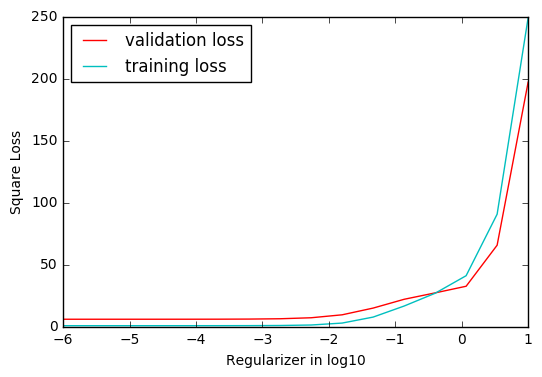

In [13]:
#L = [10**x for x in range(-5, 6)]
L = np.logspace(-6, 1, num=16)
loss = [[],[],[]]
for Lambda in L: #range(-5,6):
    #Lambda = 10**i
    
    #clf = Ridge(alpha=Lambda)
    #clf.fit(X_train, y_train)
    #loss[0].append(compute_loss(clf.coef_, X_valid, y_valid))
    
    lossy, theta = regularized_grad_descent(
        X_train, y_train, lambda_reg = Lambda, alpha =5, num_iter=1000)
    loss[1].append(compute_loss(theta[-1], X_valid, y_valid))
    loss[2].append(lossy[-1])
    #w_opt = minimize(ridge(Lambda,  X_train, y_train, w), w)
    #loss[2].append(compute_loss(w_opt.x, X_valid, y_valid))

plt.plot(np.log10(L), loss[1], 'r', label='validation loss')
plt.plot(np.log10(L), loss[2], 'c', label='training loss')
#plt.plot(np.log10(L), loss[2], 'k', label='minimize', linestyle='--')
plt.xlabel('Regularizer in log10')
plt.ylabel('Square Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#sparsity analysis for ridge regression
#lambda = 10e-5, tol = 0 -> minimize has 0% sparsity (no true zeros)
#lambda = 10e-5, tol = 10e-3 -> minimize has 6% sparsity 
tol = 10e-3
L = np.logspace(-7, 1, num=50)
percentages = [[],[],[] ]
#L = np.logspace(-5, 5, num=10)
for Lambda in L:
    #Lambda = 10**i
    
    clf = Ridge(alpha=Lambda)
    clf.fit(X_train, y_train)
    percentages[0].append(sum(abs(clf.coef_) <= tol)/D )
    
    loss, theta = regularized_grad_descent(
        X_train, y_train, lambda_reg = Lambda, alpha =5, num_iter=500)
    percentages[1].append(sum(abs(theta[-1]) <= tol)/D )
    
    w_opt = minimize(ridge(Lambda,  X_train, y_train, w), w)
    percentages[2].append(sum(abs(w_opt.x) <= tol)/D )

plt.plot(np.log10(L), percentages[0], 'r', label='sklearn ridge')
#plt.plot(np.log10(L), percentages[1], 'c', label='handwritten')
plt.plot(np.log10(L), percentages[2], 'k', label='minimize', linestyle='--')
plt.xlabel('Regularizer in log10')
plt.ylabel('Sparsity w/ 10e-3 tolerance')
plt.legend(loc='upper right')
plt.show()

In [25]:
def ridge(X, y, L):
    X2 = np.matmul(X.T, X) 
    X2[np.diag_indices_from(X2)] += L
    X2 = np.linalg.inv(X2)
    w = np.matmul( X2, np.matmul(X.T, y))
    return w 
#@timeit 
def vec_lasso(X, y, w, L, num_iter = 100):
    (num_samp, num_fea) = X.shape
    # ridge regression to init
    #w = ridge(X, y, L)
    #print(y.shape, w.shape, X.T.shape)
    for run in range(num_iter):
        
        for j in range(num_fea):
            a_j = 2*np.dot(X[:,j],X[:,j])
            
            vec = y- np.matmul(w.T, X.T) + (w*X)[:,j]
            #X2 = w* X
            #vec2 = vec + X2[:,j]  
            c_j = 2*np.dot(X[:,j], vec)

            a = c_j/a_j
            delta = L/a_j
            w[j] = np.sign(a)* max((abs(a) - delta), 0)
    return w

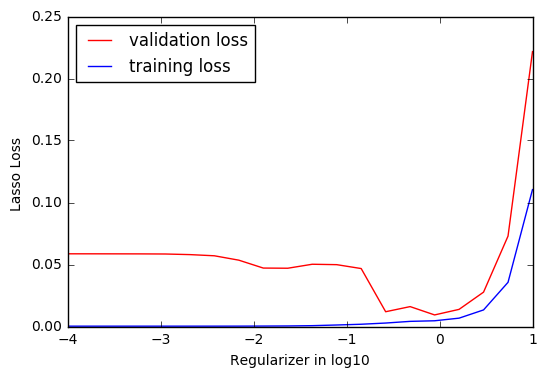

In [16]:
#searching for best lambda using validation square error 
L = np.logspace(-4, 1, num=20)
lasso_loss = []
train = []

for Lambda in L:
    w = ridge(X_train, y_train, L=Lambda)
    theta = vec_lasso(X_train, y_train, w, L = Lambda, num_iter = 1000)
    lasso_loss.append(compute_loss(theta, X_valid, y_valid)) 
    train.append(compute_loss(theta, X_train, y_train))
plt.plot(np.log10(L), lasso_loss, 'r', label='validation loss')
plt.plot(np.log10(L), train, 'b', label='training loss')

plt.xlabel('Regularizer in log10')
plt.ylabel('Lasso Loss ')
plt.legend(loc='upper left')
plt.show()

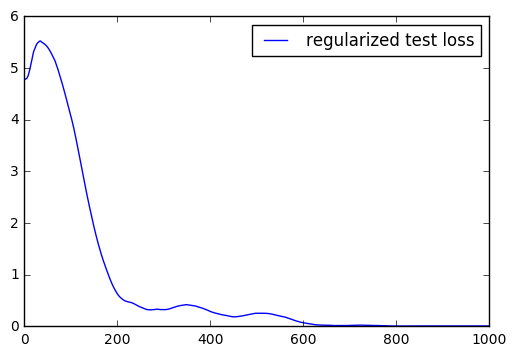

In [43]:
loss = []
w = ridge(X_train, y_train, 1)
for i in range(1000):
    w = vec_lasso(X_train, y_train, w, L = 1, num_iter = 1)
    loss.append(compute_loss(w, X_test, y_test))
    
plt.plot([x for x in range(1000)], loss, 'b', label='regularized test loss')
plt.legend()
plt.show()

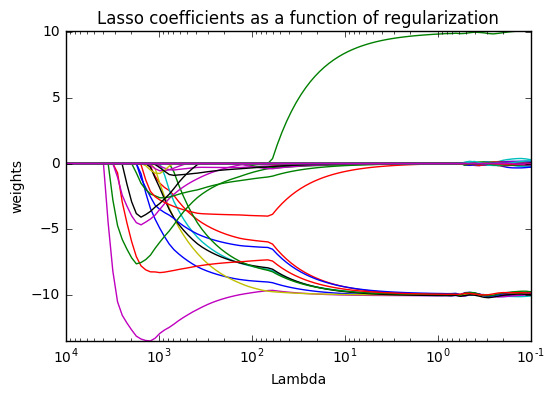

In [44]:
lambdas = np.logspace(-1, 4, 100)
coefs = []
for lamb in lambdas:
    w = ridge(X_train, y_train, L=lamb)
    theta = vec_lasso(X_train, y_train, w, lamb, num_iter = 1000)
    coefs.append(theta) 

ax = plt.gca()

ax.plot(lambdas, coefs)
#ax.axvline(30)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of regularization')
plt.axis('tight')
plt.show()

In [ ]:
tol = 0
w = ridge(X_train, y_train, L=1)
theta = vec_lasso(X_train, y_train, w, 1, num_iter = 2000)
compute_loss(theta, X_test, y_test)
#print(sum(abs(theta) <= tol)) 

In [ ]:
#@timeit
def lasso(X, y, w, L, num_iter = 100):
    (num_samp, num_fea) = X.shape

    for run in range(num_iter):
        for j in range(num_fea):
            
            a_j = 0
            c_j = 0
            for i in range(num_samp):
                
                a_j += 2*(X[i,j]**2)
            #a_j = 2*np.dot(X[:,j],X[:,j])
                
                #vec = y- np.matmul(w.T, X.T) + (w*X)[:,j]
            
                c_j += 2* X[i,j]*(y[i] - np.dot(w.T, X[i,:]) + w[j]*X[i,j])
                                  
            a = c_j/a_j
            delta = L/a_j
            w[j] = np.sign(a)* max((abs(a) - delta), 0)
    return w

In [ ]:
#@timeit
def lasso_homotopy(X, y, L):
    (num_samp, num_fea) = X.shape
    # ridge regression to init
    w = np.zeros(X.shape[1])
    #print(y.shape, w.shape, X.T.shape)
    
    while L >= 0:
        L -= 0.001
        w = vec_lasso(X, y, w, L, num_iter = 1)
    
    #print(compute_loss(w, X, y))
    return w

#for lamb in [0, 0.1, 1, 10, 100]:
 #   lasso_homotopy(X_train, y_train, lamb)

In [ ]:
@timeit
def f(inp):
    L = np.logspace(-4, 1, num=20)
    for lamb in L:
        lasso(X_train, y_train, w, L=10e-1, num_iter = 1000)
        #vec_lasso(X_train, y_train, w, L=10e-1, num_iter = 1000)
    #lasso(X_train, y_train, w, L = lamb, num_iter=200)
    return inp
l = f(7)

homotopy method over regularization path L took 139.46233 s

vectorized lasso over L took 126.85214 s

basic lasso over L took 1603  s
